# EDA

Loaded and cleaned the Nifty and BankNifty implied volatility data, handling missing values and converting columns to proper numeric types. Calculated the spread between BankNifty and Nifty, and created a shaped PnL measure. Checked summary statistics, visualized time series, and identified outlier days. Tested stationarity using ADF and KPSS, analyzed autocorrelations, and ran Ljung–Box tests to understand mean-reversion and persistence. Explored intraday patterns, rolling volatility, and high-volatility periods. Checked correlations, cointegration, and volatility regimes to gather insights for building the trading strategy.

Imported necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import gc, math, os, warnings
warnings.filterwarnings('ignore')

sns.set_style('ticks')
plt.rcParams.update({'figure.figsize': (12,7)})
DATA_PATH = '/content/drive/MyDrive/Quant_project/data.parquet'


Loaded the data from parquet file, converted the time column to datetime index, sorted by time, and ensured numeric types for key columns.

In [2]:
raw = pd.read_parquet(DATA_PATH)
if 'time' in raw.columns and not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw['time'])
    raw = raw.drop(columns=['time'])
else:
    raw.index = pd.to_datetime(raw.index)

raw = raw.sort_index()
for col in ['banknifty','nifty','tte']:
    if col in raw.columns:
        raw[col] = pd.to_numeric(raw[col], errors='coerce').astype('float32')

df = raw.copy()
print("Loaded. Rows:", len(df))
display(df.head(3))

Loaded. Rows: 690512


,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0
2021-01-01 09:16:00,0.285381,0.200432,27.0
2021-01-01 09:17:00,0.284233,0.200004,27.0


Checked for missing values in the dataset, categorized the missing data case, and applied appropriate filling/interpolation to clean the dataset.

In [3]:
print("Missing value counts:")
display(df.isna().sum())

total_cells = df.shape[0]*df.shape[1]
missing_cells = df.isna().sum().sum()
print(f"Fraction missing: {missing_cells/total_cells:.4%}")

case = None
if missing_cells == 0:
    case = "no_missing"
elif missing_cells/total_cells < 0.01:
    case = "small_gap"
else:
    case = "substantial_gaps"

print("Case selected:", case)

if case == "no_missing":
    df_clean = df.copy()
elif case == "small_gap":
    df_clean = df.interpolate(limit=5).ffill().bfill()
else:
    df_clean = df.interpolate(limit=30, limit_direction='both').ffill().bfill()

print("After simple fill, remaining NA:", df_clean.isna().sum().sum())


Missing value counts:


,0
banknifty,1500
nifty,2000
tte,0


Fraction missing: 0.1690%
Case selected: small_gap
After simple fill, remaining NA: 0


Calculated the spread between BankNifty and Nifty, created a shaped PnL measure, and took a small daily sample to preview spread statistics.

In [4]:
df_clean['spread'] = df_clean['banknifty'] - df_clean['nifty']
df_clean['pnl_shaped'] = df_clean['spread'] * (df_clean['tte'] ** 0.7)

def tiny_sample(d, n_per_day=3):
    d2 = d.copy()
    d2['date_only'] = d2.index.date
    parts = []
    for date, grp in d2.groupby('date_only'):
        parts.append(grp.sample(n=min(n_per_day, len(grp)), replace=False))
    out = pd.concat(parts).sort_index()
    return out

sample_min = tiny_sample(df_clean, n_per_day=4)
print("spread sample stats:")
display(df_clean['spread'].describe().to_frame().T)


spread sample stats:


,count,mean,std,min,25%,50%,75%,max
spread,690512.0,0.07081,0.026192,-0.007531,0.053297,0.0665,0.082269,0.209055


Resampled data to daily frequency and visualized Nifty, BankNifty, and spread trends, including a minute-level preview of the spread.

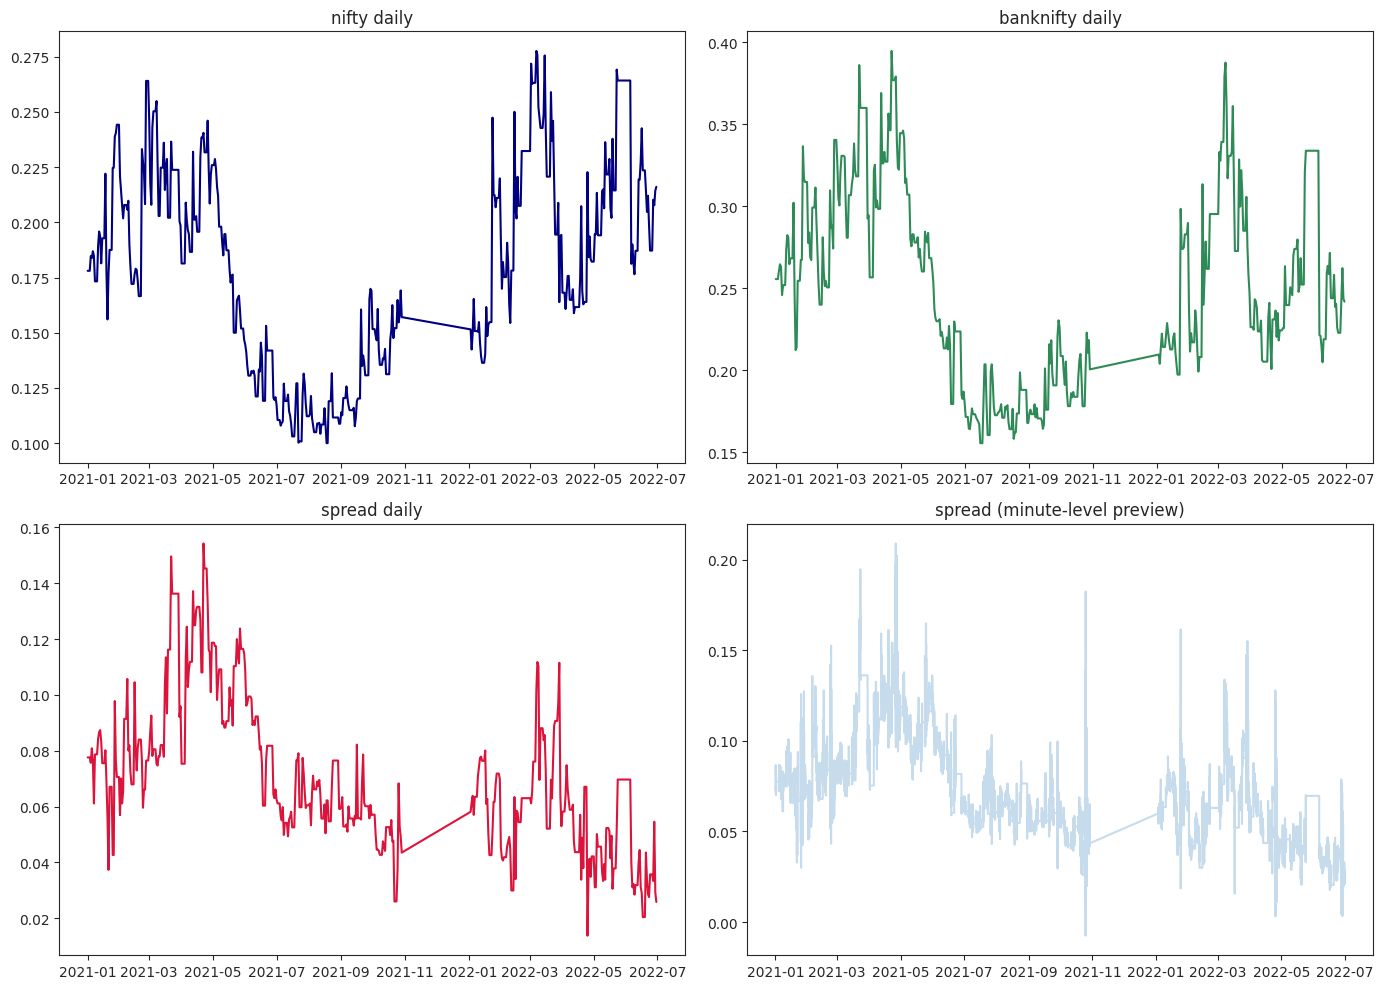

In [5]:
daily = df_clean.resample('D').last().dropna()
fig, ax = plt.subplots(2,2, figsize=(14,10))
ax = ax.flatten()
ax[0].plot(daily.index, daily['nifty'], color='navy'); ax[0].set_title('nifty daily')
ax[1].plot(daily.index, daily['banknifty'], color='seagreen'); ax[1].set_title('banknifty daily')
ax[2].plot(daily.index, daily['spread'], color='crimson'); ax[2].set_title('spread daily')
ax[3].plot(df_clean.index, df_clean['spread'], alpha=0.25); ax[3].set_title('spread (minute-level preview)')
plt.tight_layout(); plt.show()


Calculated 21-day rolling mean and standard deviation of the spread, visualized the spread with sigma bands, and identified outlier days using z-scores.

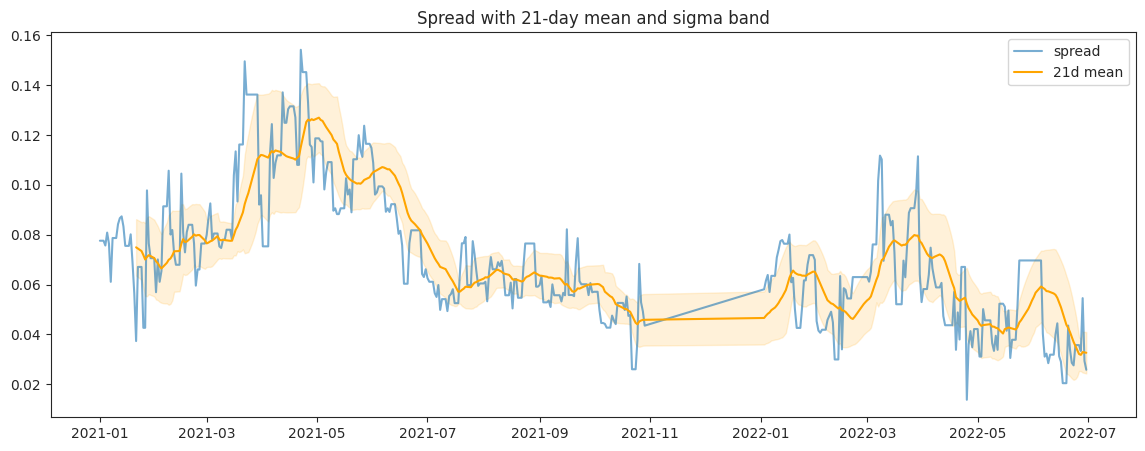

Outlier days (|z|>3): 2


,banknifty,nifty,tte,spread,pnl_shaped,rm21,std21
time,,,,,,,
2021-03-22,0.386126,0.236541,3.0,0.149585,0.322754,0.092273,0.019697
2021-04-22,0.394739,0.240525,7.0,0.154215,0.602135,0.115224,0.020676


In [6]:
W = 21
daily['rm21'] = daily['spread'].rolling(W).mean()
daily['std21'] = daily['spread'].rolling(W).std()

plt.figure(figsize=(14,5))
plt.plot(daily.index, daily['spread'], label='spread', alpha=0.6)
plt.plot(daily.index, daily['rm21'], color='orange', label='21d mean')
plt.fill_between(daily.index, daily['rm21'] - daily['std21'], daily['rm21'] + daily['std21'], color='orange', alpha=0.15)
plt.title('Spread with 21-day mean and sigma band'); plt.legend(); plt.show()

daily_z = (daily['spread'] - daily['spread'].mean()) / daily['spread'].std()
outlier_days = daily[np.abs(daily_z) > 3]
print("Outlier days (|z|>3):", len(outlier_days))
display(outlier_days.head(8))


Performed stationarity tests on daily Nifty, BankNifty, and spread using ADF and KPSS, and applied first differencing on spread if non-stationary.

In [7]:
def run_adf(x, name):
    r = adfuller(x.dropna(), autolag='AIC')
    stat, pval = r[0], r[1]
    print(f"\nADF: {name}\n  stat = {stat:.4f}\n  pval = {pval:.4f}")
    for k,v in r[4].items():
        print(f"   crit {k}: {v:.4f}")
    print("  => conclusion:", "stationary (reject H0)" if pval < 0.05 else "non-stationary (fail to reject H0)")
    return pval

def run_kpss(x, name):
    r = kpss(x.dropna(), nlags='auto')
    stat, pval = r[0], r[1]
    crit = r[3]
    print(f"\nKPSS: {name}\n  stat = {stat:.4f}\n  pval = {pval:.4f}")
    for k,v in crit.items():
        print(f"   crit {k}: {v:.4f}")
    print("  => conclusion:", "non-stationary (reject H0)" if pval < 0.05 else "stationary (fail to reject H0)")
    return pval

print("Running stationarity suite:")
p_adf_nifty = run_adf(daily['nifty'], 'nifty (daily)')
p_kpss_nifty = run_kpss(daily['nifty'], 'nifty (daily)')
p_adf_bank = run_adf(daily['banknifty'], 'banknifty (daily)')
p_kpss_bank = run_kpss(daily['banknifty'], 'banknifty (daily)')
p_adf_sp = run_adf(daily['spread'], 'spread (daily)')
p_kpss_sp = run_kpss(daily['spread'], 'spread (daily)')

if p_adf_sp > 0.05:
    print("\nSpread seems non-stationary by ADF. Trying first difference and re-test.")
    daily['spread_d1'] = daily['spread'].diff().dropna()
    run_adf(daily['spread_d1'].dropna(), 'spread diff (daily)')


Running stationarity suite:

ADF: nifty (daily)
  stat = -2.1764
  pval = 0.2149
   crit 1%: -3.4443
   crit 5%: -2.8677
   crit 10%: -2.5700
  => conclusion: non-stationary (fail to reject H0)

KPSS: nifty (daily)
  stat = 0.6681
  pval = 0.0164
   crit 10%: 0.3470
   crit 5%: 0.4630
   crit 2.5%: 0.5740
   crit 1%: 0.7390
  => conclusion: non-stationary (reject H0)

ADF: banknifty (daily)
  stat = -2.4873
  pval = 0.1186
   crit 1%: -3.4443
   crit 5%: -2.8677
   crit 10%: -2.5700
  => conclusion: non-stationary (fail to reject H0)

KPSS: banknifty (daily)
  stat = 0.6445
  pval = 0.0186
   crit 10%: 0.3470
   crit 5%: 0.4630
   crit 2.5%: 0.5740
   crit 1%: 0.7390
  => conclusion: non-stationary (reject H0)

ADF: spread (daily)
  stat = -3.0520
  pval = 0.0303
   crit 1%: -3.4441
   crit 5%: -2.8676
   crit 10%: -2.5700
  => conclusion: stationary (reject H0)

KPSS: spread (daily)
  stat = 1.9034
  pval = 0.0100
   crit 10%: 0.3470
   crit 5%: 0.4630
   crit 2.5%: 0.5740
   crit 1%:

Plotted ACF and PACF for the spread to analyze autocorrelations, and performed Ljung-Box test to check for serial correlation and mean-reversion.

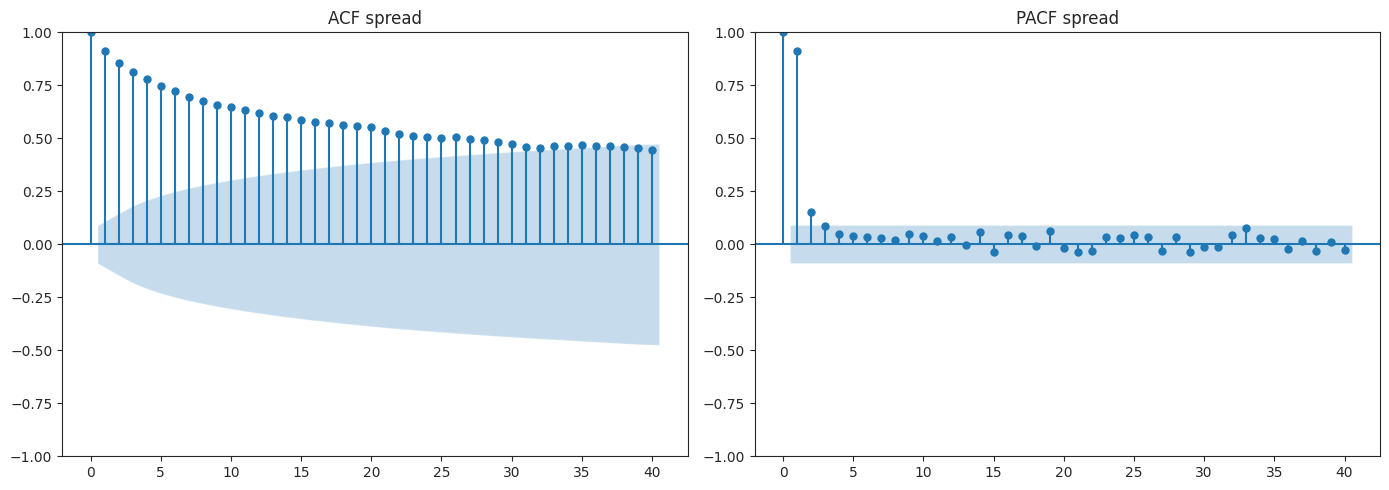

Ljung-Box test results (spread):


,lb_stat,lb_pvalue
10,2785.157838,0.0
20,4504.040477,0.0
30,5789.302471,0.0


In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(daily['spread'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF spread')
plt.subplot(1,2,2)
plot_pacf(daily['spread'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF spread')
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(daily['spread'].dropna(), lags=[10,20,30], return_df=True)
print("Ljung-Box test results (spread):")
display(lb)


Tested for long-term equilibrium between Nifty and BankNifty using Engle-Granger and Johansen cointegration tests, and checked stationarity of the resulting candidate cointegrated series.

In [9]:
eg = coint(daily['nifty'].dropna(), daily['banknifty'].dropna())
print("Engle-Granger test:")
print(f"  t-stat = {eg[0]:.4f}, p-val = {eg[1]:.4f}")
print("  =>", "cointegrated (p<0.05)" if eg[1] < 0.05 else "no cointegration (p>=0.05)")

print("\nJohansen test (trace):")
try:
    jr = coint_johansen(daily[['nifty','banknifty']].dropna(), det_order=0, k_ar_diff=1)
    for i,(stat,crit) in enumerate(zip(jr.lr1, jr.cvt[:,1])):
        print(f" r<={i} : trace={stat:.4f}, 5%crit={crit:.4f}, ->", "Reject" if stat>crit else "Do not reject")
    if jr.lr1[0] > jr.cvt[0,1]:
        vec = jr.evec[:,0]
        daily['coint_series'] = daily['nifty']*vec[0] + daily['banknifty']*vec[1]
        print("\nADF on candidate cointegrated series:")
        run_adf(daily['coint_series'].dropna(), 'coint_series')
except Exception as ex:
    print("Johansen failed:", str(ex))


Engle-Granger test:
  t-stat = -2.5417, p-val = 0.2610
  => no cointegration (p>=0.05)

Johansen test (trace):
 r<=0 : trace=24.2136, 5%crit=15.4943, -> Reject
 r<=1 : trace=8.7014, 5%crit=3.8415, -> Reject

ADF on candidate cointegrated series:

ADF: coint_series
  stat = -3.0581
  pval = 0.0298
   crit 1%: -3.4441
   crit 5%: -2.8676
   crit 10%: -2.5700
  => conclusion: stationary (reject H0)


Aggregated the spread to 5-min and 15-min intervals to visualize intraday patterns, and identified high-volatility “hotspot” periods using rolling standard deviation of 15-min bars.

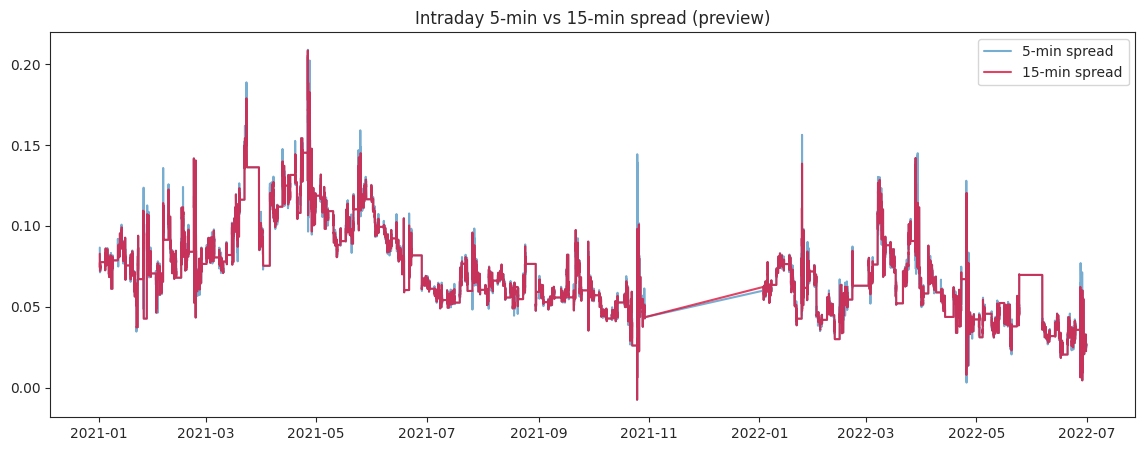

Hotspot windows (top 1% vol): 461


,spread
time,
2021-01-21 15:45:00,0.012172
2021-01-22 09:30:00,0.015355
2021-01-22 09:45:00,0.017449
2021-01-22 10:00:00,0.018330
2021-01-22 10:15:00,0.019061
2021-01-22 10:30:00,0.017607
2021-01-22 10:45:00,0.013838
2021-01-25 09:30:00,0.015247


In [10]:
df_min = df_clean.copy()
agg_5 = df_min['spread'].resample('5T').last().dropna()
agg_15 = df_min['spread'].resample('15T').last().dropna()

plt.figure(figsize=(14,5))
plt.plot(agg_5.index, agg_5, alpha=0.6, label='5-min spread')
plt.plot(agg_15.index, agg_15, alpha=0.8, label='15-min spread', color='crimson')
plt.legend(); plt.title('Intraday 5-min vs 15-min spread (preview)')
plt.show()

# hotspots: 15-min windows with top 1% volatility
vol15 = agg_15.rolling(8).std()  # roughly 2 hours windows of 15-min bars
thr = vol15.quantile(0.99)
hotspots = vol15[vol15 >= thr]
print("Hotspot windows (top 1% vol):", len(hotspots))
display(hotspots.head(8))


Filtered trading hours and calculated hourly statistics for the spread, then ran ANOVA to test if mean spreads differ significantly across hours.

In [11]:
intr = df_clean.copy()
intr['hour'] = intr.index.hour
mask_trade = (intr['hour']>=9)&(intr['hour']<=15)
mask_trade &= ~((intr['hour']==9)&(intr.index.minute<15))
mask_trade &= ~((intr['hour']==15)&(intr.index.minute>30))
intr = intr[mask_trade]

hourly_means = intr.groupby(intr.index.hour)['spread'].agg(['mean','std','count'])
print("Hourly spread summary (mean,std,count):")
display(hourly_means)

groups = [intr[intr.index.hour==h]['spread'].dropna() for h in range(9,16)]
f, p = st.f_oneway(*groups)
print(f"ANOVA across hours: F={f:.4f}, p={p:.4f}")


Hourly spread summary (mean,std,count):


,mean,std,count
time,,,
9,0.072424,0.027186,21645
10,0.071920,0.026665,28860
11,0.072142,0.026547,28860
12,0.072079,0.026478,28860
13,0.071811,0.026520,28860
14,0.071639,0.026255,28860
15,0.070920,0.026028,14911


ANOVA across hours: F=5.9351, p=0.0000


Classified days into low, medium, and high volatility based on 21-day rolling std, counted each class, and analyzed persistence by measuring consecutive high-volatility days.

In [12]:
daily['std_21'] = daily['spread'].rolling(21).std()
low_q, high_q = daily['std_21'].quantile([0.33,0.66])
daily['vol_class'] = 'Medium'
daily.loc[daily['std_21']<=low_q,'vol_class'] = 'Low'
daily.loc[daily['std_21']>=high_q,'vol_class'] = 'High'

counts = daily['vol_class'].value_counts()
print("Volatility class counts:")
display(counts)

# persistence: consecutive high days
daily['is_high'] = daily['vol_class']=='High'
daily['high_group'] = (daily['is_high'] != daily['is_high'].shift()).cumsum()
high_runs = daily[daily['is_high']].groupby('high_group').size()
print("High-volatility run lengths (summary):")
display(high_runs.describe())


Volatility class counts:


,count
vol_class,
Medium,172
High,157
Low,152


High-volatility run lengths (summary):


,0
count,11.000000
mean,14.272727
std,14.806018
min,1.000000
25%,4.500000
50%,9.000000
75%,16.500000
max,42.000000


Used squared spread as a proxy for volatility, visualized its 5-day rolling average, and applied Ljung-Box test to check for volatility clustering.

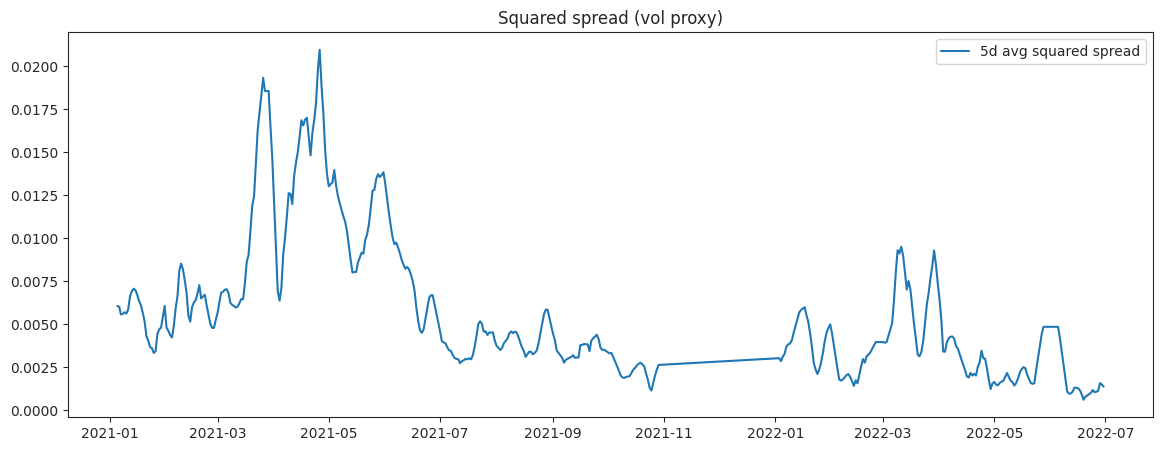

Ljung-Box on squared spread (vol clustering proxy):


,lb_stat,lb_pvalue
5,1666.084133,0.0
10,2787.166261,0.0
20,4492.759344,0.0


In [13]:
daily['spread_sq'] = daily['spread']**2
plt.figure(figsize=(14,5))
plt.plot(daily['spread_sq'].rolling(5).mean(), label='5d avg squared spread')
plt.title('Squared spread (vol proxy)')
plt.legend(); plt.show()

lb_sq = acorr_ljungbox(daily['spread_sq'].dropna(), lags=[5,10,20], return_df=True)
print("Ljung-Box on squared spread (vol clustering proxy):")
display(lb_sq)


Calculated autocorrelations of the spread with its 1- and 2-day lags and visualized them, and plotted the 30-day rolling correlation between Nifty and BankNifty to study their relationship over time.

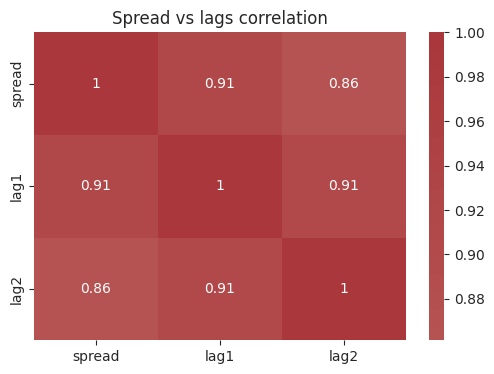

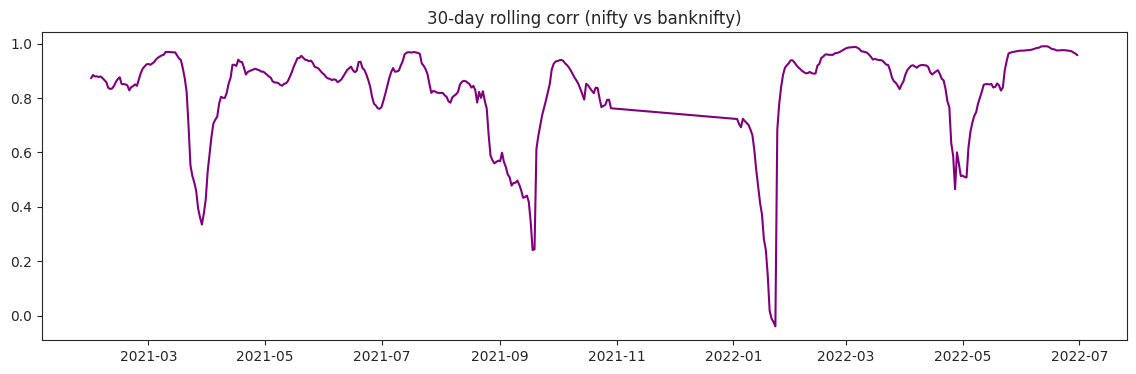

In [14]:
daily['lag1'] = daily['spread'].shift(1)
daily['lag2'] = daily['spread'].shift(2)
corrmat = daily[['spread','lag1','lag2']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corrmat, annot=True, cmap='vlag', center=0)
plt.title('Spread vs lags correlation')
plt.show()

daily['corr_30'] = daily['nifty'].rolling(30).corr(daily['banknifty'])
plt.figure(figsize=(14,4))
plt.plot(daily['corr_30'], color='purple'); plt.title('30-day rolling corr (nifty vs banknifty)'); plt.show()


In [18]:
summary = {
    'total_days': len(daily),
    'outlier_days': len(outlier_days),
    'hotspot_15min': len(hotspots),
    'engle_granger_p': float(eg[1]),
    'spread_adf_p': float(p_adf_sp),
    'spread_kpss_p': float(p_kpss_sp)
}
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['value'])
display(summary_df)

res_dir = '/content/drive/MyDrive/Quant_project/results'
os.makedirs(res_dir, exist_ok=True)
daily[['spread','std_21','vol_class']].to_csv(os.path.join(res_dir,'eda_daily_summary.csv'))
summary_df.to_csv(os.path.join(res_dir,'eda_summary.csv'))
print("EDA artifacts saved to:", res_dir)

gc.collect()


,value
total_days,481.000000
outlier_days,2.000000
hotspot_15min,461.000000
engle_granger_p,0.261009
spread_adf_p,0.030315
spread_kpss_p,0.010000


EDA artifacts saved to: /content/drive/MyDrive/Quant_project/results


31